In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import sys
from matplotlib.colors import to_rgba
# adding Folder_2/subfolder to the system path
sys.path.insert(0, '/work/ccnr/glover.co/net_design/NetDesign')
import network_design as nd
import netrd
import matplotlib.pyplot as plt

In [3]:
# Read in dataset
df = pd.read_csv('../../data/protein_complex/corum_hint_combined.txt',index_col=False)

In [23]:
def logbin(x,y,bins=10):
    """
    Log bin values of y based on x.
    """
    kmin = np.min(x)
    kmax = np.max(x)
    C = (kmax/kmin)**(1/bins)
    binned_x = np.zeros(bins)
    binned_y = np.zeros(bins)
    for b in range(bins):
        # Get cur bin max
        bin_max = C**(b+1)*kmin
        bin_min = C**(b)*kmin
        cur_x = x[x<bin_max]
        cur_y = y[x<bin_max]
        cur_y = cur_y[cur_x>=bin_min]
        cur_x = cur_x[cur_x>=bin_min]
        binned_x[b] = np.mean(cur_x)
        binned_y[b] = np.mean(cur_y)
    return binned_x, binned_y

In [4]:
# Make networks
complex_ids = pd.unique(df['complex_id'])

In [9]:
len(complex_ids)

1910

In [5]:
distinct_complexes = {}

In [6]:
for i in complex_ids:
    # Get rows
    cur_id = df[df.complex_id == i]
    g = nx.Graph()
    for index, row in cur_id.iterrows():
        g.add_edge(row['Uniprot_A'],row['Uniprot_B'])
    if g.number_of_nodes() == 0:
        continue
    distinct_complexes[i] = g

In [18]:
# Dataset statistics
number_of_complexes = len(distinct_complexes.keys())
size_of_complexes = np.zeros(number_of_complexes)
avg_k = np.zeros(number_of_complexes)
cc = np.zeros(number_of_complexes)
cycle_basis = np.zeros(number_of_complexes)

In [19]:
for idx, i in enumerate(distinct_complexes.keys()):
    # Get network
    g = distinct_complexes[i]
    size_of_complexes[idx] = g.number_of_nodes()
    avg_k[idx] = 2*g.number_of_edges()/g.number_of_nodes()
    cc[idx] = nx.average_clustering(g)
    cycle_basis[idx] = g.number_of_edges() - g.number_of_nodes() + len(list(nx.connected_components(g)))

In [11]:
count = 0
for i in complex_ids:
    try:
        if distinct_complexes[i].number_of_nodes() > 2:
            count += 1
    except:
        continue
count

905

In [27]:
len(count_x), len(count_y)

(26, 26)

/home/glover.co/miniconda3/envs/gt/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/glover.co/miniconda3/envs/gt/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


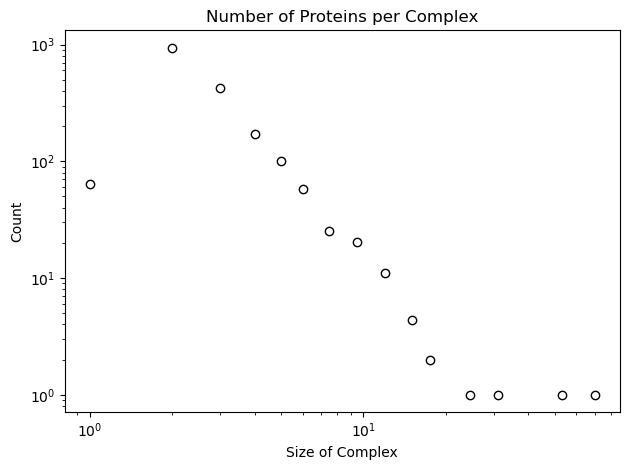

In [32]:
count_x, count_y = np.unique(size_of_complexes,return_counts=True)
x, y = logbin(count_x,count_y,bins=20)
fig, ax = plt.subplots()
ax.scatter(x,y,color='w',edgecolors='k')
ax.set_xlabel('Size of Complex')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Count')
plt.title('Number of Proteins per Complex')
plt.tight_layout()
plt.savefig('figs/size.pdf')
plt.show()

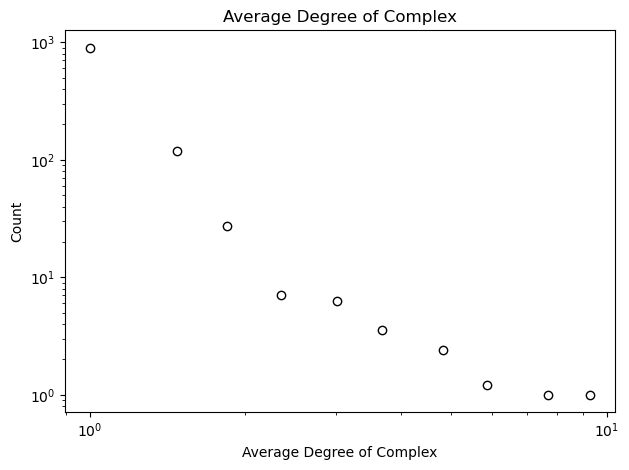

In [43]:
count_x, count_y = np.unique(avg_k,return_counts=True)
x, y = logbin(count_x,count_y,bins=10)
fig, ax = plt.subplots()
ax.scatter(x,y,color='w',edgecolors='k')
ax.set_xlabel('Average Degree of Complex')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Count')
plt.title('Average Degree of Complex')
plt.tight_layout()
plt.savefig('figs/avg_k.pdf')
# plt.loglog(x[:-1],1000*x[:-1]**(-3),'--')
plt.show()

In [57]:
# count_x[0] += .01
logbin(count_x, count_y,bins=10)

(array([1.00000000e-02,            nan,            nan,            nan,
        1.00000000e+00, 2.50000000e+00, 6.00000000e+00, 1.45000000e+01,
        3.38333333e+01, 1.44000000e+02]),
 array([1.33100000e+03,            nan,            nan,            nan,
        3.34000000e+02, 5.50000000e+01, 1.60000000e+01, 3.66666667e+00,
        1.50000000e+00, 1.00000000e+00]))

/home/glover.co/miniconda3/envs/gt/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/glover.co/miniconda3/envs/gt/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


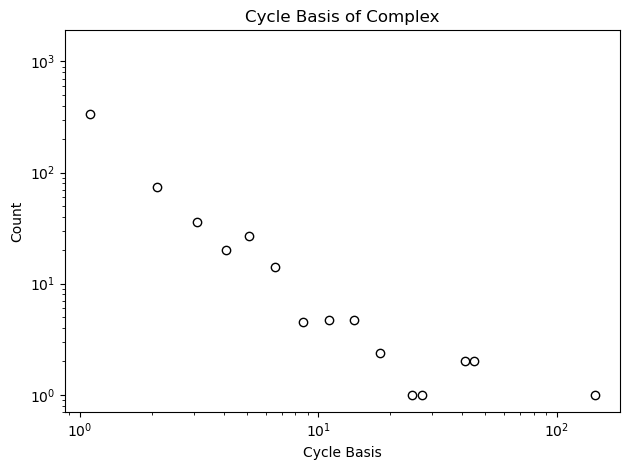

In [70]:
count_x, count_y = np.unique(cycle_basis,return_counts=True)
count_x += .1
x, y = logbin(count_x[1:],count_y[1:],bins=20)
# y,x = np.histogram(cycle_basis,bins=20)
# x = x[:-1]
fig, ax = plt.subplots()
ax.scatter(x,y,color='w',edgecolors='k')
ax.scatter(0,count_y[0],color='w',edgecolors='k')
ax.set_xlabel('Cycle Basis')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Count')
plt.title('Cycle Basis of Complex')
plt.tight_layout()
plt.savefig('figs/cycle_basis_log.pdf')
# plt.loglog(x[:-1],1000*x[:-1]**(-3),'--')
plt.show()

In [46]:
x

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

# Compare true network with reconstructed network

In [11]:
graphs = {}
for i in complex_ids:
    try:
        graphs[i] = nx.read_edgelist(f'../../data/protein_complex/graphs/g_{i}.txt')
    except:
        continue

In [12]:
reconstructed_graphs_01 = {}
for i in complex_ids:
    try:
        reconstructed_graphs_01[i] = nx.read_edgelist(f'../../data/protein_complex/reconstructed_graphs/01_g_{i}.txt')
    except:
        continue

In [13]:
reconstructed_graphs_1 = {}
for i in complex_ids:
    try:
        reconstructed_graphs_1[i] = nx.read_edgelist(f'../../data/protein_complex/reconstructed_graphs/1_g_{i}.txt')
    except:
        continue

In [15]:
connected_components_01 = np.zeros(len(complex_ids))
connected_components_1 = np.zeros(len(complex_ids))
counter = 0
node_count = np.zeros(len(complex_ids))
graphs_large = []
for idx, i in enumerate(complex_ids):
    try:
        g = graphs[i]
        if g.number_of_nodes() <= 2:
            continue
        recon_01 = reconstructed_graphs_01[i]
        recon_1 = reconstructed_graphs_1[i]
        connected_components = list(nx.connected_components(recon_01))
        for c in connected_components:
            if nx.is_isomorphic(nx.subgraph(recon_01,c),g):
                connected_components_01[counter] += 1
        connected_components = list(nx.connected_components(recon_1))
        for c in connected_components:
            if nx.is_isomorphic(nx.subgraph(recon_1,c),g):
                connected_components_1[counter] += 1
        node_count[counter] = g.number_of_edges() - g.number_of_nodes() + len(list(nx.connected_components(g)))
        counter+=1
        graphs_large.append(i)
    except:
        continue
con_comp_01_large = connected_components_01[:counter]
con_comp_1_large = connected_components_1[:counter]

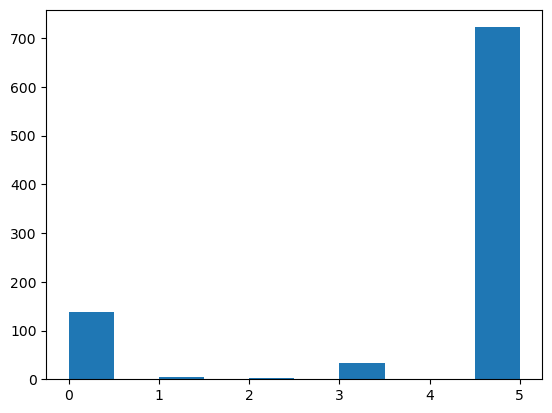

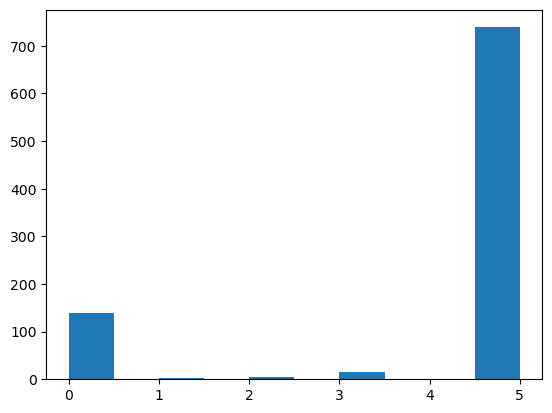

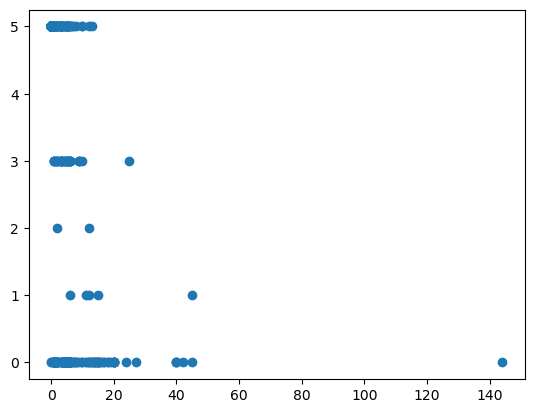

In [16]:
plt.hist(connected_components_1[:counter])
plt.show()
plt.hist(connected_components_01[:counter])
plt.show()
plt.plot(node_count[:counter],connected_components_1[:counter],'o')

In [ ]:
g = graphs[graphs_large[2]]

In [44]:
recon_1 = reconstructed_graphs_1[graphs_large[2]]
recon_01 = reconstructed_graphs_01[graphs_large[2]]

In [48]:
connected_components = list(nx.connected_components(recon_1))
for c in connected_components:
    if nx.is_isomorphic(nx.subgraph(recon_1,c),g):
        print('here')

here
here
here
here
here


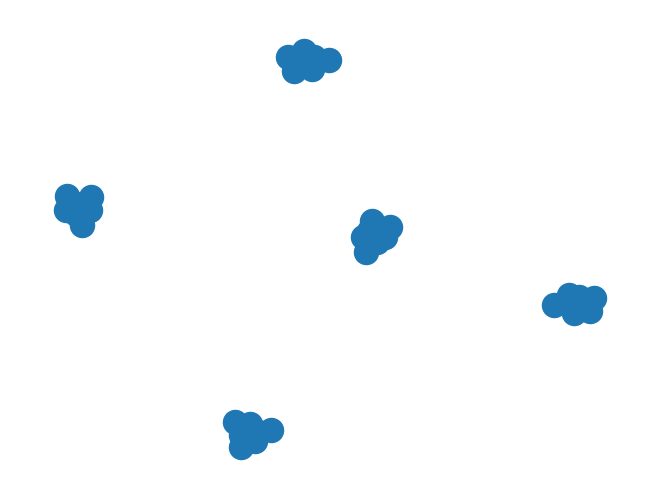

In [51]:
nx.draw(recon_1)

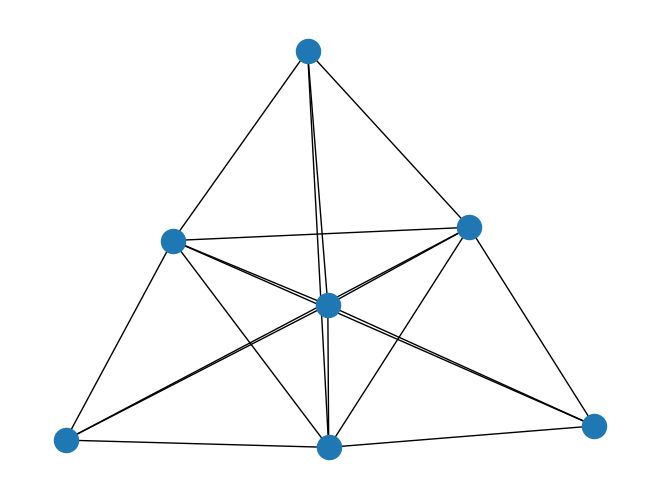

In [52]:
nx.draw(g)

In [30]:
con_comp_01_large[2]

0.0